# Season-based Logistic Regression Model

### Import Packages

In [1]:
import pandas as pd
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve
from sklearn.preprocessing import StandardScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1. Load Merged Data

In [3]:
MERGED_DATA_PATH = "/content/drive/My Drive/Capstone Project AA/Modeling/merged_data_deploy/model_final.csv"
merged_df = pd.read_csv(MERGED_DATA_PATH)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399618 entries, 0 to 399617
Data columns (total 75 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   FL_DATE                  399618 non-null  object 
 1   MKT_UNIQUE_CARRIER       399618 non-null  object 
 2   OP_CARRIER_FL_NUM        399618 non-null  int64  
 3   ORIGIN                   399618 non-null  object 
 4   DEST                     399618 non-null  object 
 5   CRS_DEP_TIME             399618 non-null  int64  
 6   DEP_TIME                 399618 non-null  int64  
 7   WHEELS_OFF               399618 non-null  float64
 8   CRS_ARR_TIME             399618 non-null  int64  
 9   ARR_TIME                 399618 non-null  int64  
 10  WHEELS_ON                399618 non-null  float64
 11  CANCELLED                399618 non-null  float64
 12  DIVERTED                 399618 non-null  float64
 13  YEAR                     399618 non-null  int64  
 14  MONT

### 2. Create Target delta_delay_sign

In [4]:
# merged_df['delta_delay_sign'] = (merged_df['delay_label_num'] < 0).astype(int)
merged_df['delta_delay_sign'] = (merged_df['delta_delay'] < 0).astype(int)
display(merged_df[['arr_delay', 'dep_delay', 'delta_delay', 'delta_delay_sign']].head())

,arr_delay,dep_delay,delta_delay,delta_delay_sign
0,16.0,44.0,-28.0,1
1,-24.0,-3.0,-21.0,1
2,-8.0,-6.0,-2.0,1
3,-6.0,6.0,-12.0,1
4,-16.0,0.0,-16.0,1


In [5]:
print("\nTarget distribution:")
print(merged_df['delta_delay_sign'].value_counts(normalize=True))


Target distribution:
delta_delay_sign
1    0.732079
0    0.267921
Name: proportion, dtype: float64


### 3. Define Numerical Columns
* **Task**: Feature selection. Select relevant numerical features and handle any remaining missing values or outliers in those features.
*
**Reasoning**:
Inspect the merged_df DataFrame to identify all columns with numerical data types and create a list of numerical columns relevant for modeling, including the target variable. Then, identify columns with missing values and their percentages to determine handling strategies.



In [6]:
# Select relevant numerical columns for modeling, including the target
# Exclude text-based columns and the specified columns
# Include directions

relevant_numerical_cols = [
    'DEP_visibility_mi',
    'MONTH',
    'ARR_visibility_mi',
    'ARR_wind_speed_kt',
    'ARR_dewpoint_C',
    'DEP_dewpoint_C',
    'DEP_wind_speed_kt',
    'ARR_temp_C',
    'DEP_pressure_mb',
    'ARR_pressure_mb',
    'DEP_temp_C',
    #'CRS_DEP_TIME_UTC_MIN',
    # 'ARR_TIME_UTC_MIN',   # adding this caused data leakage
    #'DEP_TIME_UTC_MIN',
    'ARR_wind_dir_deg',
    'DEP_wind_dir_deg',
    #'CRS_ARR_TIME_UTC_MIN',
    'AIRCRAFT_TYPE',
    'FLIGHT_DIRECTION_VECTOR', # Add when using preprocessed and premerged data
    'dep_delay',
    'delta_delay_sign' # Include the target variable
]

# Filter numerical_cols to include only those in relevant_numerical_cols
numerical_cols = [col for col in relevant_numerical_cols if col in merged_df.columns]

print("\nRelevant numerical columns for modeling:", numerical_cols)

# Identify missing values in selected numerical columns
missing_numerical_values = merged_df[numerical_cols].isnull().sum()
print("\nMissing values per relevant numerical column:")
print(missing_numerical_values[missing_numerical_values > 0])

# Calculate percentage of missing values
missing_numerical_percentage = merged_df[numerical_cols].isnull().mean() * 100
print("\nPercentage of missing values per relevant numerical column:")
print(missing_numerical_percentage[missing_numerical_percentage > 0])


Relevant numerical columns for modeling: ['DEP_visibility_mi', 'MONTH', 'ARR_visibility_mi', 'ARR_wind_speed_kt', 'ARR_dewpoint_C', 'DEP_dewpoint_C', 'DEP_wind_speed_kt', 'ARR_temp_C', 'DEP_pressure_mb', 'ARR_pressure_mb', 'DEP_temp_C', 'ARR_wind_dir_deg', 'DEP_wind_dir_deg', 'AIRCRAFT_TYPE', 'FLIGHT_DIRECTION_VECTOR', 'dep_delay', 'delta_delay_sign']

Missing values per relevant numerical column:
DEP_visibility_mi      625
ARR_visibility_mi      756
ARR_wind_speed_kt    26677
ARR_dewpoint_C        9891
DEP_dewpoint_C        9361
DEP_wind_speed_kt    24808
ARR_temp_C            6223
DEP_pressure_mb        387
ARR_pressure_mb        387
DEP_temp_C            6323
ARR_wind_dir_deg     29961
DEP_wind_dir_deg     27749
dtype: int64

Percentage of missing values per relevant numerical column:
DEP_visibility_mi    0.156399
ARR_visibility_mi    0.189181
ARR_wind_speed_kt    6.675625
ARR_dewpoint_C       2.475114
DEP_dewpoint_C       2.342487
DEP_wind_speed_kt    6.207929
ARR_temp_C          

### 4. Helper Function: Train & Evaluate Logistic Regression for a Season

In [7]:
season_results = {}

def train_logreg_for_season(df, season_name):
    print("="*70)
    print(f"Training Logistic Regression for {season_name}...")
    print("="*70)

    # -------------------------
    # Step 1: Prepare X and y
    # -------------------------
    X = df[numerical_cols].drop(columns=['delta_delay_sign'])
    y = df['delta_delay_sign']

    # -------------------------
    # Step 2: Train-test split
    # -------------------------
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # -------------------------
    # Step 3: Missing value imputation (median)
    # -------------------------
    cols_to_impute = X_train.columns[X_train.isnull().any()].tolist()
    for col in cols_to_impute:
        median_val = X_train[col].median()
        X_train[col] = X_train[col].fillna(median_val)
        X_test[col] = X_test[col].fillna(median_val)

    # -------------------------
    # Step 4: Standardization
    # -------------------------
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # -------------------------
    # Step 5: Train Logistic Regression
    # -------------------------
    model = LogisticRegression(
        random_state=42,
        solver='lbfgs',
        class_weight='balanced'
    )
    model.fit(X_train_scaled, y_train)

    # -------------------------
    # Step 6: Evaluation
    # -------------------------
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]

    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_proba)
    }

    # Store everything
    season_results[season_name] = {
        "model": model,
        "scaler": scaler,
        "X_test_scaled": X_test_scaled,
        "y_test": y_test,
        "y_pred": y_pred,
        "y_proba": y_proba
    }

    print(f"{season_name} stored.")

    print("\nPerformance Metrics for:", season_name)
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

    return metrics

### 5. Define Season Splits

In [8]:
winter_df = merged_df[merged_df["MONTH"].isin([12, 1, 2])]
spring_df = merged_df[merged_df["MONTH"].isin([3, 4, 5])]
summer_df = merged_df[merged_df["MONTH"].isin([6, 7, 8])]
fall_df   = merged_df[merged_df["MONTH"].isin([9, 10, 11])]

print("\nSeason sizes:")
print("Winter:", winter_df.shape)
print("Spring:", spring_df.shape)
print("Summer:", summer_df.shape)
print("Fall:", fall_df.shape)


Season sizes:
Winter: (97392, 76)
Spring: (99935, 76)
Summer: (99779, 76)
Fall: (102512, 76)


### 6. Train Seasonal Models and Original Model

In [9]:
winter_metrics = train_logreg_for_season(winter_df, "Winter")
spring_metrics = train_logreg_for_season(spring_df, "Spring")
summer_metrics = train_logreg_for_season(summer_df, "Summer")
fall_metrics   = train_logreg_for_season(fall_df, "Fall")
original_metrics = train_logreg_for_season(merged_df, "Whole year")

Training Logistic Regression for Winter...
Winter stored.

Performance Metrics for: Winter
Accuracy: 0.5548
Precision: 0.7598
Recall: 0.5601
F1: 0.6449
AUC: 0.5716
Training Logistic Regression for Spring...
Spring stored.

Performance Metrics for: Spring
Accuracy: 0.5622
Precision: 0.7393
Recall: 0.5777
F1: 0.6486
AUC: 0.5709
Training Logistic Regression for Summer...
Summer stored.

Performance Metrics for: Summer
Accuracy: 0.5524
Precision: 0.7716
Recall: 0.5523
F1: 0.6438
AUC: 0.5701
Training Logistic Regression for Fall...
Fall stored.

Performance Metrics for: Fall
Accuracy: 0.5655
Precision: 0.7941
Recall: 0.5918
F1: 0.6782
AUC: 0.5466
Training Logistic Regression for Whole year...
Whole year stored.

Performance Metrics for: Whole year
Accuracy: 0.5548
Precision: 0.7708
Recall: 0.5576
F1: 0.6471
AUC: 0.5713


### 7. Summary Table

In [10]:
summary = pd.DataFrame([
    winter_metrics,
    spring_metrics,
    summer_metrics,
    fall_metrics,
    original_metrics
], index=["Winter", "Spring", "Summer", "Fall", "Whole year"])

print("\n\n=================== Summary of All Seasons ===================")
display(summary)




=================== Summary of All Seasons ===================


,Accuracy,Precision,Recall,F1,AUC
Winter,0.554751,0.759842,0.560139,0.644884,0.571553
Spring,0.562165,0.739333,0.577652,0.648568,0.570877
Summer,0.552415,0.771554,0.552347,0.643803,0.570094
Fall,0.565527,0.794078,0.591803,0.678179,0.546587
Whole year,0.554765,0.770839,0.557587,0.647097,0.571252


- **Summer** performs the best overall, with the highest AUC and strong F1.

- **Fall** shows the highest precision, meaning its positive predictions are more reliable.

- Season-based models **slightly outperform** the whole-year model, suggesting that seasonal patterns help the classifier.

- Overall, season splitting provides small but consistent improvements over the baseline.

## Visualization

### 1. Confusion Matrix

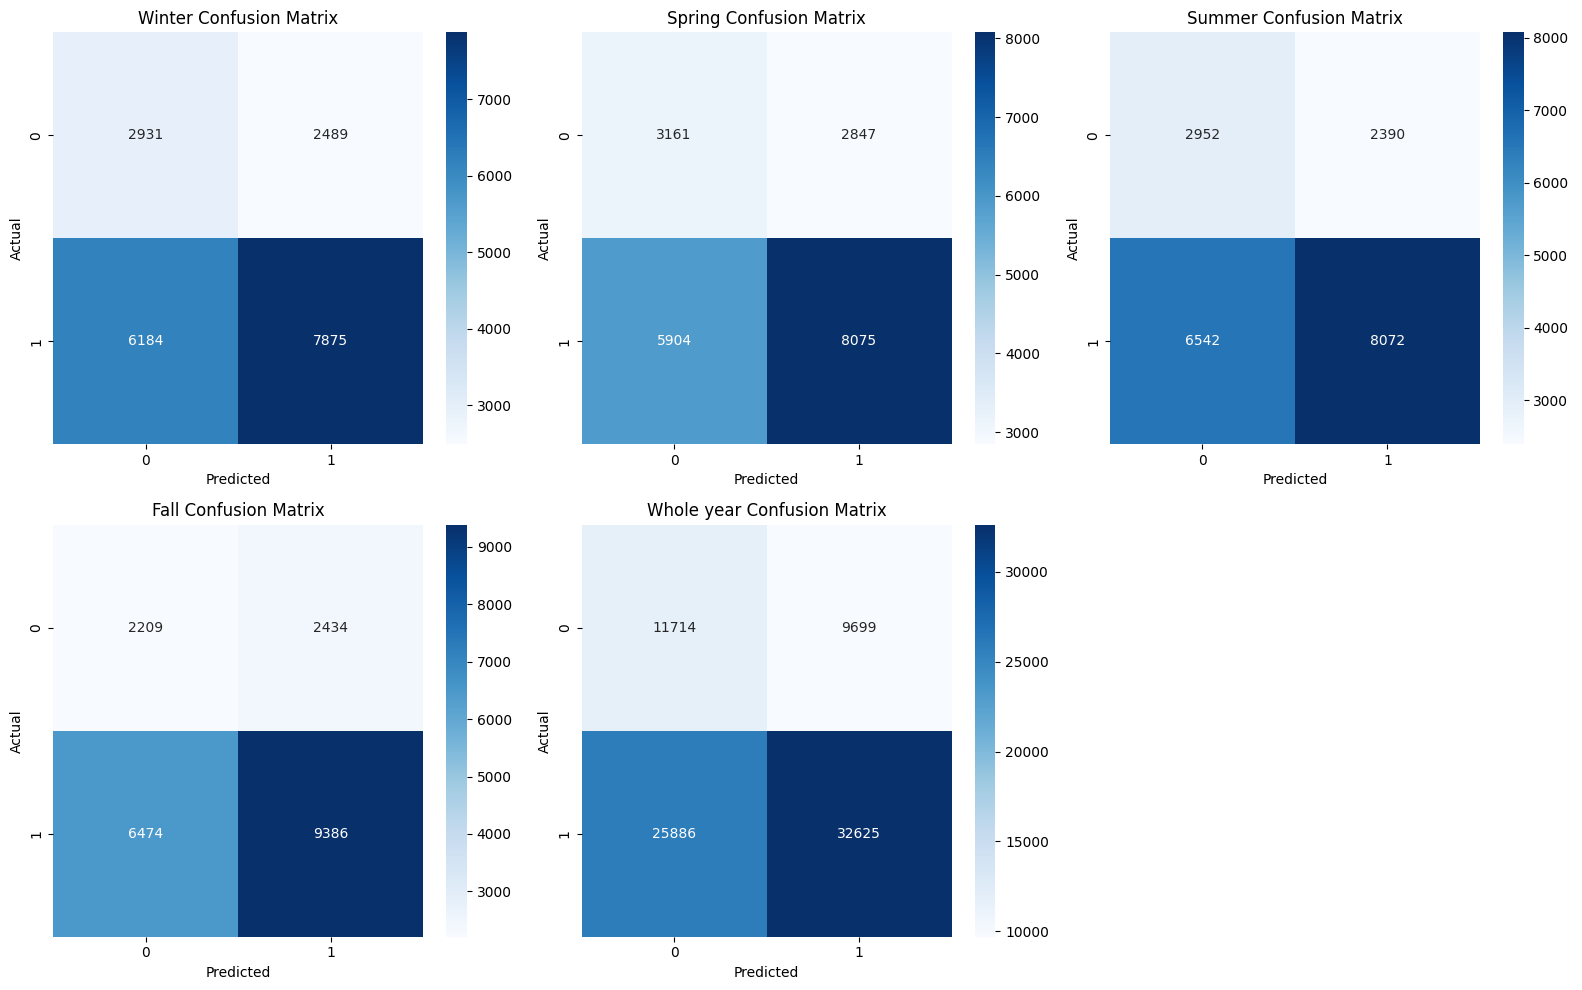

In [11]:
# =====================================================
# Confusion Matrix Subplots (2×3)
# =====================================================

import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

season_list = ["Winter", "Spring", "Summer", "Fall", "Whole year"]

for idx, season in enumerate(season_list):
    res = season_results[season]
    y_test = res["y_test"]
    y_pred = res["y_pred"]

    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", ax=axes[idx])
    axes[idx].set_title(f"{season} Confusion Matrix")
    axes[idx].set_xlabel("Predicted")
    axes[idx].set_ylabel("Actual")

# Hide last empty subplot if only 5 seasons
axes[-1].axis("off")

plt.tight_layout()
plt.show()


### 2. ROC Curve

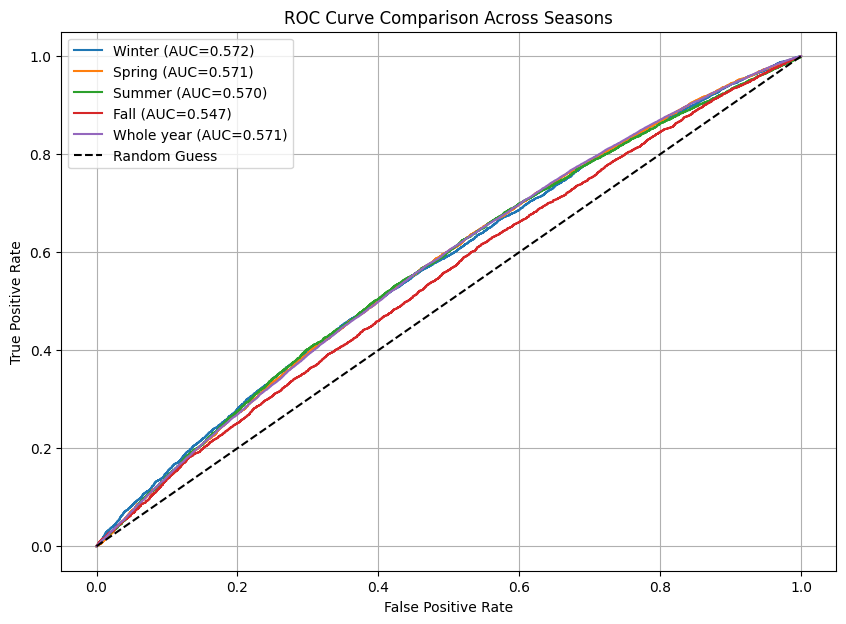

In [12]:
# =====================================================
# ROC Curve for all seasons
# =====================================================

plt.figure(figsize=(10, 7))

for season in season_list:
    res = season_results[season]
    y_test = res["y_test"]
    y_proba = res["y_proba"]

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_val = roc_auc_score(y_test, y_proba)

    plt.plot(fpr, tpr, label=f"{season} (AUC={auc_val:.3f})")

plt.plot([0,1], [0,1], 'k--', label="Random Guess")
plt.title("ROC Curve Comparison Across Seasons")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()
